In [ ]:
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)

In [ ]:
def generate_ancestors(t=10, sigma=20):
    """
    generate ancestors of the process according to a Poisson process
    with intensity sigma in [0,t]
    :param t: time interval
    :param sigma: intensity of the process
    :return: list of ancestors
    """
    ancestors = []
    time = 0
    while time <= t:
        x = np.random.exponential(1/sigma)
        ancestors.append(time)
        time += x

    return ancestors


def sigma(t):
    """
    compute sigma(t) = 20 * Identity(t)_{10<=t<=20}
    :param t: time
    :return: sigma(t)
    """
    if t <= 10: return 20
    else: return 0

In [ ]:
def h_rv(n, _lambda=0.1, _type='uni'):
    """
    fertility function, returns the "delta t" for a new infection
    :param n: number of value to generate
    :param _lambda:
    :param _type: type of the RV distribution
    :return: array of "delta t"
    """
    if _type == 'uni':
        return np.random.uniform(0, 20, size=n)  # uniform [0, 20]
    if _type == 'exp':
        # return stats.expon.rvs(scale=1/_lambda, size=n)  # lambda*exp{-lambda*t}
        return np.random.exponential(1/_lambda, size=n)


def h(t, _lambda=0.1, _type='uni'):
    """
    fertility function of the stocastical intensity
    :param t: time array
    :param _lambda:
    :param _type: type of fertility function
    :return: return h(t) for each value of t
    """
    if _type == 'uni':
        res = np.zeros(len(t))
        res[(t >= 0) & (t <= 20)] = 1/20
        return res
    else:
        # return _lambda*np.exp(-_lambda * t)
        return _lambda*np.exp(-_lambda*t)

In [ ]:
class HawkesProcess:
    """
    class that implements a Hawkes Process simulator:
    2 different techniques are used:
    - Inner branching structure (branching)
    - Otaga thinning method (thinning)
    """
    def __init__(self, T):
        self.T = T  # run simulation for t in [0, T]

        self.branching_res = dict()
        self.thinning_res = dict()

        self.m = 2
        self.death_probability = 0.02


    def branching(self, _type):
        """
        Simulate an Hawkes process exploiting its inner branchins structure
        :param _type: type of fertility function h(t)
        :return: l: list of infected at each generation -> not used
                 infected: list of infection times
                 deaths: list of deaths at each generation -> not used
        """
        ancestors = generate_ancestors()
        l = [ancestors]
        deaths = []
        infected = []

        for i in range(self.T):
            print(f"gen: {i}, nodes: {len(l[i])}")
            death = np.random.random(size=len(l[i]))
            death = death[death < self.death_probability]
            deaths.append(len(death))

            nodes_i = []
            for parents_time in l[i]:
                infected.append(parents_time)

                n = stats.poisson.rvs(self.m)  # generate children

                taus = h_rv(n, _type=_type)
                t_w = np.array(taus) + parents_time

                # not add childs above time threshold

                nodes_i.extend(t_w[t_w < self.T])

            l.append(nodes_i)
            if len(nodes_i) == 0:  # exit if process is extinct
                break

        return l, infected, deaths


    def simulate_branching(self, _type, n_runs=1):
        """
        Simulate the Hawkes process exploiting its inner branchins structure
        for n_runs and compute the condidence interval
        :param _type: type of fertility funciton
        :param n_runs: number of distinct runs
        """
        res = []
        for i in range(n_runs):
            np.random.seed(i)
            res.append(self.branching(_type=_type))

        self.branching_res[_type] = res


    def plot_brenching(self):
        res_uni = self.branching_res['uni']  # generations_list, infected_times, deaths_times
        res_exp = self.branching_res['exp']

        plt.figure(figsize=(10,7))

        # TO-DO confidence interval

        plt.hist(res_exp[0][1], bins=self.T, label='exponential', alpha=0.5)
        plt.hist(res_uni[0][1], bins=self.T, label='uniform', alpha=0.5)

        plt.xlabel("days", fontsize=14)
        plt.ylabel("number of infected", fontsize=14)
        plt.grid()
        plt.legend()
        plt.savefig("res/brenching_infected_hist.png")
        plt.show()


    def plot_branching_deaths(self):
        res_uni = self.branching_res['uni'][0][1]
        res_exp = self.branching_res['exp'][0][1]

        # TO-DO confidence interval
        b_exp = np.histogram(res_exp, bins=self.T)[0] * 0.02
        b_uni = np.histogram(res_uni, bins=self.T)[0] * 0.02

        plt.figure(figsize=(10,7))
        plt.plot(np.linspace(start=1, stop=self.T, num=self.T), np.cumsum(b_exp), label='eponential')
        plt.plot(np.linspace(start=1, stop=self.T, num=self.T), np.cumsum(b_uni), label='uniform')
        plt.xlabel("days", fontsize=14)
        plt.ylabel("cumulative number of deaths", fontsize=14)
        plt.grid()
        plt.legend()
        plt.savefig("res/branching_deaths_cum_attenuation.png")
        plt.show()

        plt.figure(figsize=(10,7))
        plt.plot(np.linspace(start=1, stop=self.T, num=self.T), b_exp, label='eponential')
        plt.plot(np.linspace(start=1, stop=self.T, num=self.T), b_uni, label='uniform')
        plt.xlabel("days", fontsize=14)
        plt.ylabel("number of deaths", fontsize=14)
        plt.grid()
        plt.legend()
        plt.savefig("res/branching_deaths_attenuation.png")
        plt.show()


    def rho(self, t, time_set):
        """
        compute rho, the factor that simulates the introduction of non pharmaceutical
        interventions, that reduces the stochastic intensity
        :param t: time
        :param time_set: the set of times of the hawkes process, used to compute the
                         number of deaths of the previous days
        :return: rho(t)
        """
        n = 7  # time window
        ts = np.array(time_set) - (math.floor(t)-n)
        num_infected = len(ts[ (ts >= 0) & (ts <= n) ])  # number of infected the day before
        num_deaths = num_infected * 0.02  # number of deaths the day before

        if num_deaths >= 25*n:  # [50, inf)
            return 0.5  # red flag
        elif 15*n <= num_deaths < 25*n:  # [25, 50)
            return 0.75  # yellow flag
        else:  # [0, 25]
            return 1  # white flag


    def stochastic_intensity(self, time_set, t, m=2, _type='uni', attenuation=False):
        """
        compute the stochastic intensity
        :param time_set: set of times
        :param t: time
        :param m: reproduction factor
        :param _type: type of fertility function
        :param attenuation: if there is attenuation (i.e. if compute rho(t) or not)
        :return: lambda(t|H_t)
        """
        ts = np.array(time_set)
        arr = (t - ts)[(t - ts) > 0]

        if (attenuation is True) and (t >= 20):  # only after t=20
            return sigma(t) + (self.rho(t, ts) * m * np.sum(h(arr, _type=_type)))

        return sigma(t) + (m * np.sum(h(arr, _type=_type)))


    def thinning(self, T, _type='uni', attenuation=False):
        """
        Apply the Ogata thinning algorithm to simulate the Hawkes process
        using the implementations proposed in https://perso.lpsm.paris/~msangnier/files/papers/spl2021.pdf
        to limit the computation of the stochastic intensity at 1 time for each t instead of 2
        :param T: max time
        :param _type: type of fertility function
        :param attenuation: if there is attenuation (i.e. if compute rho(t) or not)
        :return: list of infection times
        """
        # d = dict()
        # time_set = SortedSet()
        time_set = []
        _lambda_0 = _lambda_k = sigma(0)
        t_k = 0
        n = t = 0
        while t_k < T:
            # print(s)
            _lambda_max = max(_lambda_0, _lambda_k)
            u1 = np.random.uniform()
            t_cand = t_k - np.log(u1)/_lambda_max
            _lambda_k = self.stochastic_intensity(time_set, t_cand, m=self.m, _type=_type, attenuation=attenuation)
            u2 = np.random.uniform()

            if u2*_lambda_max <= _lambda_k:
                n += 1
                if t_k >= t:
                    print(t_k)
                    t += 1
                time_set.append(t_cand)

            t_k = t_cand

        return time_set


    def simulate_thinning(self, _type, attenuation, T=-1, n_runs=1):
        """
        simulate the Hawkes process multiple time and compute the
        confidence interval
        :param _type:
        :param attenuation:
        :param T: max time
        :param n_runs: number of different runs
        """
        if T == -1:
            T = self.T
        res = []
        for i in range(n_runs):
            np.random.seed(i)
            res.append(self.thinning(T, _type=_type, attenuation=attenuation))

        self.thinning_res[_type] = res


    def plot_thinning(self, T=-1):
        if T == -1:
            T = self.T

        res_uni = self.thinning_res['uni']
        res_exp = self.thinning_res['exp']

        plt.figure(figsize=(10,7))

        # TO-DO confidence interval

        plt.hist(res_exp[0], bins=T, label='exponential', alpha=0.5)
        plt.hist(res_uni[0], bins=T, label='uniform', alpha=0.5)

        plt.xlabel("days", fontsize=14)
        plt.ylabel("number of infected", fontsize=14)
        plt.grid()
        plt.legend()
        plt.savefig("res/thinning_infected_hist_attenuation.png")
        plt.show()


    def plot_comparison(self):
        res_uni_b = self.branching_res['uni'][0][1]
        res_exp_b = self.branching_res['exp'][0][1]
        res_uni_t = self.thinning_res['uni'][0]
        res_exp_t = self.thinning_res['exp'][0]

        plt.figure(figsize=(10,7))

        # TO-DO confidence interval
        b_uni_b = np.histogram(res_uni_b, bins=self.T)[0]
        b_exp_b = np.histogram(res_exp_b, bins=self.T)[0]
        b_uni_t = np.histogram(res_uni_t, bins=self.T)[0]
        b_exp_t = np.histogram(res_exp_t, bins=self.T)[0]
        plt.plot(np.linspace(start=1, stop=50, num=50), b_exp_b, label='branching-exponential')
        plt.plot(np.linspace(start=1, stop=50, num=50), b_uni_b, label='branching-uniform')
        plt.plot(np.linspace(start=1, stop=50, num=50), b_exp_t, label='thinning-exponential')
        plt.plot(np.linspace(start=1, stop=50, num=50), b_uni_t, label='thinning-uniform')


        plt.xlabel("days", fontsize=14)
        plt.ylabel("number of infected", fontsize=14)
        plt.grid()
        plt.legend()
        plt.savefig("res/comparison_infected_hist.png")
        plt.show()


    def plot_thinning_deaths(self, T=-1):
        if T == -1:
            T = self.T

        res_uni = self.thinning_res['uni']
        res_exp = self.thinning_res['exp']

        # TO-DO confidence interval
        b_exp = np.histogram(res_exp[0], bins=T)[0] * 0.02
        b_uni = np.histogram(res_uni[0], bins=T)[0] * 0.02

        plt.figure(figsize=(10,7))
        plt.plot(np.linspace(start=1, stop=T, num=T), np.cumsum(b_exp), label='eponential')
        plt.plot(np.linspace(start=1, stop=T, num=T), np.cumsum(b_uni), label='uniform')
        plt.xlabel("days", fontsize=14)
        plt.ylabel("cumulative number of deaths", fontsize=14)
        plt.grid()
        plt.legend()
        plt.savefig("res/thinning_deaths_cum_attenuation.png")
        plt.show()

        plt.figure(figsize=(10,7))
        plt.plot(np.linspace(start=1, stop=T, num=T), b_exp, label='eponential')
        plt.plot(np.linspace(start=1, stop=T, num=T), b_uni, label='uniform')
        plt.xlabel("days", fontsize=14)
        plt.ylabel("number of deaths", fontsize=14)
        plt.grid()
        plt.legend()
        plt.savefig("res/thinning_deaths_attenuation.png")
        plt.show()


    def plot_rho(self, T=-1):
        if T == -1:
            T = self.T

        res_uni = self.thinning_res['uni']
        res_exp = self.thinning_res['exp']
        rho_uni = []
        rho_exp = []
        for i in range(T):
            rho_exp.append(1/(self.rho(i, res_exp[0])**2))
            rho_uni.append(1/(self.rho(i, res_uni[0])**2))

        plt.figure(figsize=(10,7))
        plt.plot(rho_uni, label='uniform')
        plt.plot(rho_exp, label='exponential')
        plt.xlabel("days", fontsize=14)
        plt.ylabel("cost: 1/(rho(t)^2)", fontsize=14)
        plt.grid()
        plt.legend()
        plt.savefig("res/thinning_cost_attenuation.png")
        plt.show()

    def confidence_interval(self, arr, T):
        pass

In [ ]:
s = HawkesProcess(50)

In [ ]:
s.simulate_branching('uni')
s.simulate_branching('exp')
s.plot_brenching()

In [ ]:
s.plot_branching_deaths()

In [ ]:
s.simulate_thinning('uni', attenuation=False)
s.simulate_thinning('exp', attenuation=False)
s.plot_comparison()

In [ ]:
s.simulate_thinning('uni', attenuation=True, T=120)
s.simulate_thinning('exp', attenuation=True, T=120)

In [ ]:
s.plot_thinning(T=120)

In [ ]:
s.plot_thinning_deaths(T=120)

In [ ]:
s.plot_rho(T=120)

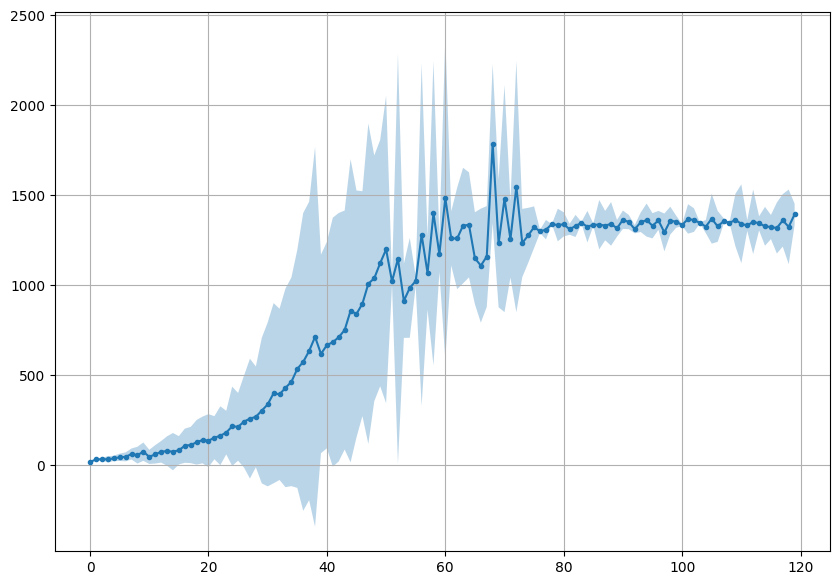

In [60]:
# import pandas as pd
# arr = np.histogram(s.thinning_res['uni'], bins=120)[0]
# arr = np.stack([arr, np.histogram(s.thinning_res['exp'], bins=120)[0]])
#
# df = pd.DataFrame(arr)
# mean = df.mean()
# var = df.var()
# # 95% confidence interval
# t_crit = stats.t.ppf(q=0.95, df=len(df))
#
# down_i = mean - t_crit * np.sqrt(var)/np.sqrt(len(df))
# up_i = mean + t_crit * np.sqrt(var)/np.sqrt(len(df))
#
# # plot
# plt.figure(figsize=(10, 7))
#
# plt.fill_between(x=df.columns, y1=up_i, y2=down_i, alpha=.3)
#
# plt.plot(mean, marker=".")
# plt.grid()
# plt.show()

In [ ]:
# 659000 infected

In [ ]:
# per simulazione seconda parte cercare di tenere lambda fisso quando raggiunge un certo valore (rho = 2)
# mantenere rt = 1

In [ ]:
# https://github.com/migmtz/hawkes-inhibition-expon/blob/main/code/hawkes_process.py
#
# https://www.youtube.com/watch?v=mwJXjxMTwAw
#
# https://www.pythonbid.com/post/pandemic-modeling-with-python-the-sir-model
#
# https://python.quantecon.org/sir_model.html
#
# to cite:
# https://www.math.fsu.edu/~ychen/research/Thinning%20algorithm.pdf
# https://perso.lpsm.paris/~msangnier/files/papers/spl2021.pdf
# https://arxiv.org/pdf/1711.01679.pdf
